In [101]:
import sys
import platform
print("Python version:\n", sys.version)
print ("Path to the python executable:\n", sys.executable)

Python version:
 3.6.10 |Anaconda, Inc.| (default, May  7 2020, 19:46:08) [MSC v.1916 64 bit (AMD64)]
Path to the python executable:
 C:\Users\user\anaconda3\envs\py36\python.exe


In [102]:
%matplotlib inline
import os
import psutil
import numpy as np
import keras as K
import h5py
import time
import tensorflow as tf 
import sys; sys.argv=['']; del sys

from argparser import args
from model import unet

if args.keras_api:
    import keras as K
else:
    from tensorflow import keras as K

import matplotlib.pyplot as plt

onnx=False
plot_result = True
#TODO - Enable nGraph Bridge - Switch to (decathlon) venv!
# import ngraph_bridge

if onnx:
    #TODO - Include ngraph onnx backend
    import onnx
    from ngraph_onnx.onnx_importer.importer import import_onnx_model
    import ngraph as ng

print ("We are using Tensorflow version", tf.__version__,\
       "with Intel(R) MKL", "enabled" if tf.pywrap_tensorflow.IsMklEnabled() else "disabled",)

We are using Tensorflow version 1.15.0 with Intel(R) MKL disabled


In [120]:
# Create output directory for images
png_directory = "inference_examples"
if not os.path.exists(png_directory):
    os.makedirs(png_directory)
    
data_filename = os.path.join(args.data_path, args.data_filename)
model_filename = os.path.join(args.output_path, args.inference_filename)

unet_model_for_decathlon.hdf5


In [104]:
def calc_dice(target, prediction, smooth=0.01):
    """
    Sorensen Dice coefficient
    """
    prediction = np.round(prediction)

    numerator = 2.0 * np.sum(target * prediction) + smooth
    denominator = np.sum(target) + np.sum(prediction) + smooth
    coef = numerator / denominator

    return coef

def calc_soft_dice(target, prediction, smooth=0.01):
    """
    Sorensen (Soft) Dice coefficient - Don't round preictions
    """
    numerator = 2.0 * np.sum(target * prediction) + smooth
    denominator = np.sum(target) + np.sum(prediction) + smooth
    coef = numerator / denominator

    return coef

In [107]:
df = h5py.File(data_filename, "r")
imgs_testing = df["imgs_testing"][1]
print(imgs_testing)
msks_testing = df["msks_testing"]
print(msks_testing)
files_testing = df["testing_input_files"]
print(files_testing)

<HDF5 dataset "imgs_testing": shape (6624, 144, 144, 4), type "<f8">
<HDF5 dataset "msks_testing": shape (6624, 144, 144, 1), type "<f8">
<HDF5 dataset "testing_input_files": shape (46,), type "|O">


In [106]:
unet_model = unet()
model = unet_model.load_model(model_filename)

Data format = channels_last


In [117]:
def plot_results(model, imgs_validation, msks_validation, img_no, png_directory):

    img = imgs_validation[[img_no], ]
    msk = msks_validation[[img_no], ]
    
    #TODO load onnx model in ngraph
    if onnx:
        onnx_protobuf = onnx.load('output/unet_model_for_decathlon_100_iter.onnx')
        ng_models = import_onnx_model(onnx_protobuf)
        ng_model = ng_models[0]
        runtime = ng.runtime(backend_name='CPU')
        unet = runtime.computation(ng_model['output'], *ng_model['inputs'])
        
        start_time = time.time()
        pred_mask= unet(img)[0]
        print ("Time for prediction ngraph: ", '%.0f'%((time.time()-start_time)*1000),"ms")

    else:
        start_time = time.time()
        pred_mask = model.predict(img, verbose=0, steps=None)
        print ("Time for prediction TF: ", '%.0f'%((time.time()-start_time)*1000),"ms")
        
    if args.plot:
        plt.figure(figsize=(10, 10))
        plt.subplot(1, 3, 1)
        plt.imshow(img[0, :, :, 0], cmap="bone", origin="lower")
        plt.title("MRI")
        plt.axis("off")
        plt.subplot(1, 3, 2)
        plt.imshow(msk[0, :, :, 0], origin="lower")
        plt.title("Ground Truth")
        plt.axis("off")
        plt.subplot(1, 3, 3)
        plt.imshow(pred_mask[0, :, :, 0], origin="lower")
        plt.title("Prediction\n(Dice = {:.4f})".format(calc_dice(msk, pred_mask)))
        plt.axis("off")

        png_filename = os.path.join(png_directory, "pred_{}.png".format(img_no))
        plt.savefig(png_filename, bbox_inches="tight", pad_inches=0)
        print("Dice {:.4f}, Soft Dice {:.4f}, Saved png file to: {}".format(
            calc_dice(msk, pred_mask), calc_soft_dice(msk, pred_mask), png_filename))

Time for prediction TF:  220 ms
Dice 0.9059, Soft Dice 0.9058, Saved png file to: inference_examples\pred_100.png
Time for prediction TF:  221 ms
Dice 0.8990, Soft Dice 0.8984, Saved png file to: inference_examples\pred_101.png
Time for prediction TF:  240 ms
Dice 0.8976, Soft Dice 0.8962, Saved png file to: inference_examples\pred_102.png
Time for prediction TF:  216 ms
Dice 0.9043, Soft Dice 0.9034, Saved png file to: inference_examples\pred_103.png
Time for prediction TF:  218 ms
Dice 0.9108, Soft Dice 0.9109, Saved png file to: inference_examples\pred_104.png
Time for prediction TF:  217 ms
Dice 0.9024, Soft Dice 0.9026, Saved png file to: inference_examples\pred_105.png
Time for prediction TF:  216 ms
Dice 0.9009, Soft Dice 0.9012, Saved png file to: inference_examples\pred_106.png


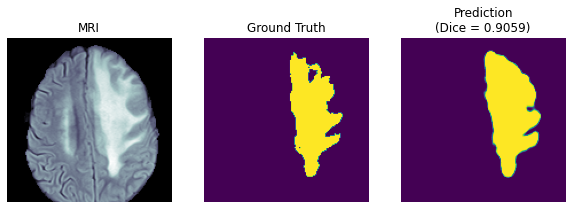

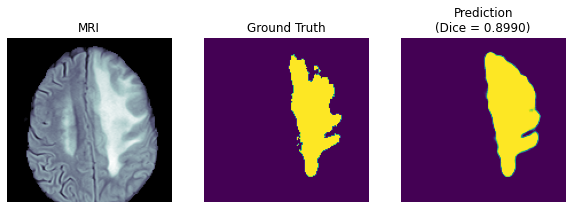

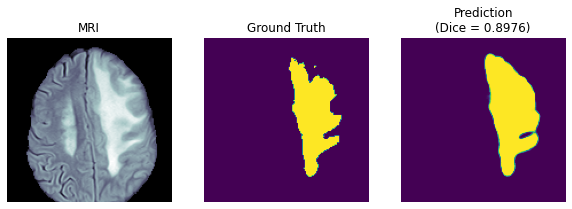

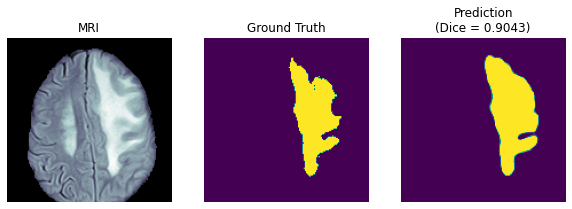

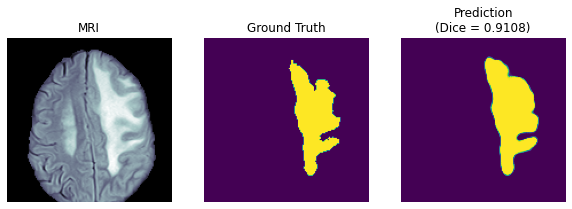

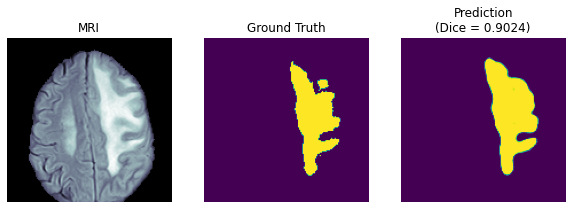

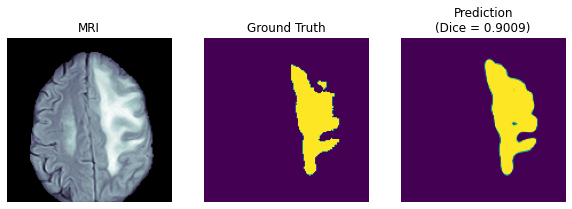

In [125]:
indicies_validation = [100,101,102,103,104,105,106 ] #[40]

for idx in indicies_validation:
    plot_results(model, imgs_testing, msks_testing,
                 idx, args.output_pngs)